In [22]:
import os

import xarray as xr
import numpy  as np
import pandas as pd
from scipy import stats as scipy_stats 
from scipy import signal # another correlation algorrythm

import matplotlib.pyplot as plt
from   matplotlib import gridspec
import datashader as ds
from datashader.mpl_ext import dsshow
import cartopy.crs as ccrs
import cartopy.feature as cf

ceres_dir = '/work/mh0926/m300872/ceres/'
file_list = [ceres_dir+e for e in os.listdir(ceres_dir) if '.nc' in e]
ceres = xr.open_mfdataset(file_list)
ceres

<xarray.Dataset>
Dimensions:                           (time: 192168, lon: 20, lat: 10)
Coordinates:
  * time                              (time) datetime64[ns] 2000-03-01T00:30:...
  * lon                               (lon) float32 300.5 301.5 ... 318.5 319.5
  * lat                               (lat) float32 10.5 11.5 12.5 ... 18.5 19.5
Data variables: (12/53)
    cldarea_high_1h                   (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    cldarea_mid_high_1h               (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    cldarea_mid_low_1h                (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    cldarea_low_1h                    (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    cldarea_total_1h                  (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    adj_atmos_sw_up_all_toa_1h        (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    ...                                ...
    adj_atmos_lw_down_clr_toa_1h      (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    adj_atmos_lw_down_clr_70mb_1h     (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    adj_atmos_lw_down_clr_200mb_1h    (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    adj_atmos_lw_down_clr_500mb_1h    (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    adj_atmos_lw_down_clr_850mb_1h    (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
    adj_atmos_lw_down_clr_surface_1h  (time, lat, lon) float32 dask.array<chunksize=(44784, 10, 20), meta=np.ndarray>
Attributes:
    title:        CERES SYN1deg 1-Hourly data
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:       
    Version:      Edition 4.1: Release Date August 22, 2019
    DOI:          10.5067/Terra+Aqua/CERES/SYN1deg-1Hour_L3.004A
    Fill_Value:   Fill Value is -999.0

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


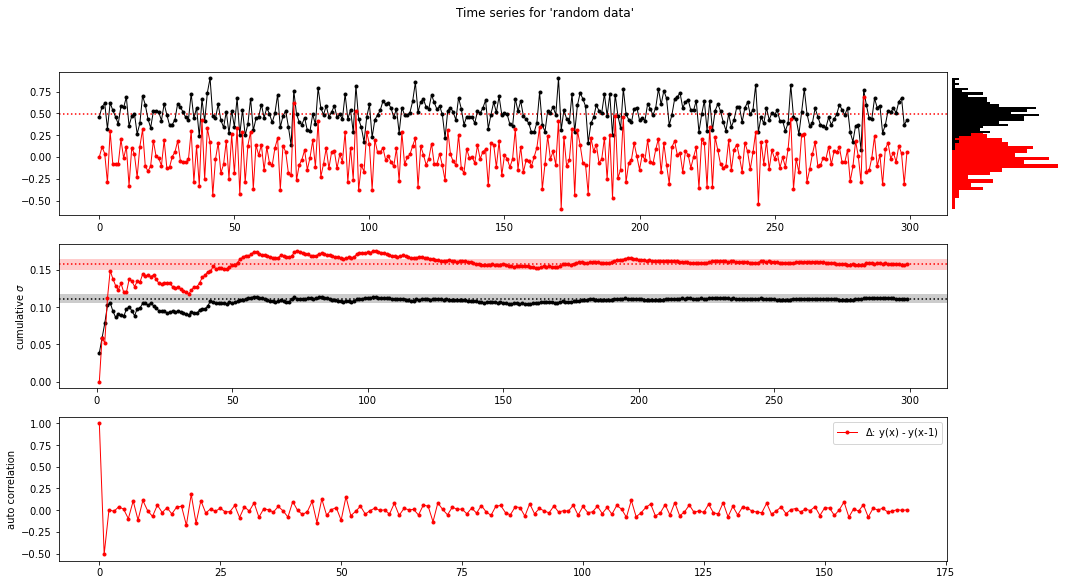

In [34]:

def time_series_boxplot(x,y,var, title=False, companion='box'):
    if not title: title = var

    # create a figure
    fig = plt.figure(figsize=(18,9))
    fig.suptitle('Time series for \'' + title + '\'')
    # create grid for different subplots
    if companion == 'box':
        spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[4, 1], wspace=-0.16)
    elif companion == 'hist':
        spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[4, 0.5], wspace=0.01)
    axs = [fig.add_subplot(spec[0]), fig.add_subplot(spec[1]), fig.add_subplot(spec[2]),fig.add_subplot(spec[4])]
    axs[0].get_shared_y_axes().join(axs[1],axs[0])

    # 1: series and detrended series
    # calc
    y_diff = []
    for i, e in enumerate(y):
        if i == 0: y_diff.append(0)
        else:      y_diff.append(e - y[i-1])
    # plot
    if companion == 'box':
        axs[1].boxplot(y, whis=(5, 95), medianprops=dict(color='red', linewidth=2), 
                       boxprops=dict(linewidth=0.4), flierprops=dict(markersize=2))
    elif companion == 'hist':
        axs[1].hist(y_diff, bins=int(len(y_diff)/10), orientation="horizontal",color='red')
        axs[1].hist(y,      bins=int(len(y)/10),      orientation="horizontal",color='black')
    axs[1].axis('off')
    axs[0].axhline(np.median(y), color='red', linestyle=':')
    axs[0].plot(x, y,      marker='.', linewidth=1, color='black')
    axs[0].plot(x, y_diff, marker='.', linewidth=1, color='red')
   
    # 2: relative standard deviation
    # calc
    std     = [np.sqrt((i - np.mean(y))**2)  for i in y] # standard deviation
    std_cum = [np.average(std[0:i]) for i, e in enumerate(std)] # cumulative standard deviation
    axs[2].plot(x, std_cum , marker='.', color='black',  linewidth=1)
    axs[2].axhline(std_cum[-1], color='black', linestyle=':')
    axs[2].axhspan(std_cum[-1]*0.95, std_cum[-1]*1.05, color='black', alpha=0.2, linewidth=0)
    
    std     = [np.sqrt((i - np.mean(y_diff))**2)  for i in y_diff] # standard deviation
    std_cum = [np.average(std[0:i]) for i, e in enumerate(std)] # cumulative standard deviation
    axs[2].plot(x, std_cum , marker='.', color='red',  linewidth=1)
    axs[2].axhline(std_cum[-1], color='red', linestyle=':')
    axs[2].axhspan(std_cum[-1]*0.95, std_cum[-1]*1.05, color='red', alpha=0.2, linewidth=0)
    axs[2].set_ylabel("cumulative $\sigma$")
 
    # plot 3: autocorrelation
    def normalize_series(x):
        return (x - np.min(x))/np.ptp(x)
    def scale_to_one(x):
        return x / np.max(np.abs(x))
    def autocorr(x):
        # result = np.correlate(x, x, mode='full')
        result = signal.correlate(x, x, mode='full', method='auto')
        return result[int(result.size/2):]
  #  axs[3].plot(autocorr(y),      marker='.', color='black',  linewidth=1, label='data: y(x)')
    axs[3].plot(scale_to_one(autocorr(y_diff))[0:24*7], marker='.', color='red',    linewidth=1, label='$\Delta$: y(x) - y(x-1)')
    axs[3].set_ylabel("auto correlation")
    axs[3].legend()
    
    # axis labels
    # axs[0].set_xlabel('model time [h]')
    if var == 'cre': 
        axs[0].set_ylabel("CRE [$W/m^2$]")
    elif var == 'clt': 
        axs[0].set_ylabel("global mean cloud amount")
    else:
        try: axs[0].set_ylabel(ds[var].units)
        except: pass
    return fig


x = np.asarray(range(300))
# print(x)
y = [i + 1 for i in x]
y = np.random.rand(len(x)) #* 2 -1
y = np.random.normal(loc=0.5, scale=0.15, size=len(x))
# print(min(y),np.mean(y),max(y))


fig = time_series_boxplot(x,y,'random data', companion='hist')
plt.show()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


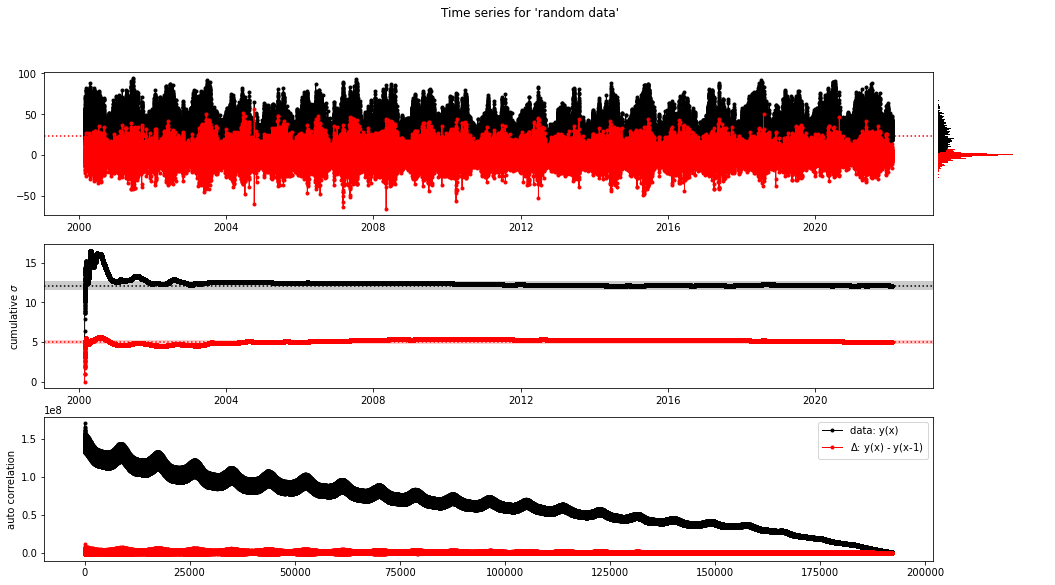

In [23]:
var = 'cldarea_low_1h'
x = ceres.time
# print(x)
y = [np.average(timestep) for timestep in ceres[var]]
# y = ceres[var].values
# print(min(y),np.mean(y),max(y))



fig = time_series_boxplot(x,y,'random data', companion='hist')
plt.show()

@array_function_dispatch(_correlate_dispatcher)
def correlate(a, v, mode='valid'):
    """
    Cross-correlation of two 1-dimensional sequences.

    This function computes the correlation as generally defined in signal
    processing texts::

        c_{av}[k] = sum_n a[n+k] * conj(v[n])

    with a and v sequences being zero-padded where necessary and conj being
    the conjugate.

    Parameters
    ----------
    a, v : array_like
        Input sequences.
    mode : {'valid', 'same', 'full'}, optional
        Refer to the `convolve` docstring.  Note that the default
        is 'valid', unlike `convolve`, which uses 'full'.
    old_behavior : bool
        `old_behavior` was removed in NumPy 1.10. If you need the old
        behavior, use `multiarray.correlate`.

    Returns
    -------
    out : ndarray
        Discrete cross-correlation of `a` and `v`.

    See Also
    --------
    convolve : Discrete, linear convolution of two one-dimensional sequences.
    multiarray.correlate :

('correlate', <built-in function correlate>)
('correlate2', <built-in function correlate2>)


TypeError: module, class, method, function, traceback, frame, or code object was expected, got builtin_function_or_method

In [28]:
import os

import xarray as xr
import numpy  as np
import pandas as pd
from scipy import stats as scipy_stats 
from scipy import signal # another correlation algorrythm

import matplotlib.pyplot as plt
from   matplotlib import gridspec
import datashader as ds
from datashader.mpl_ext import dsshow
import cartopy.crs as ccrs
import cartopy.feature as cf

# open data
ceres_dir = '/work/mh0926/m300872/ceres/'
# ceres_dir = '/Users/admin/ceres/'
file_list = [ceres_dir+e for e in os.listdir(ceres_dir) if '.nc' in e]
ceres = xr.open_mfdataset(file_list)

# discard variables
yes_list = ['time', 'lat', 'lon',
            'cldarea_high_1h', 'cldarea_mid_high_1h', 'cldarea_mid_low_1h', 'cldarea_low_1h', 'cldarea_total_1h', 
            'adj_atmos_lw_down_clr_surface_1h', 'adj_atmos_lw_up_clr_surface_1h', 'adj_atmos_sw_down_clr_surface_1h', 
            'adj_atmos_sw_up_clr_surface_1h', 'dj_atmos_lw_down_all_surface_1h', 'adj_atmos_lw_up_all_surface_1h', 
            'adj_atmos_sw_down_all_surface_1h', 'adj_atmos_sw_up_all_surface_1h', 'adj_atmos_lw_down_all_surface_1h']
no_list  = [name for name in list(ceres.variables) if name not in yes_list]
ceres = ceres.drop(labels=no_list)

# # # calculate radiation budgets
calculations = [
    {'short_name' : 'lw_net_all', 'long_name' : 'All-Sky Longwave Net Flux, Hourly Daily Means', 
     'components' : ['adj_atmos_lw_up_all_surface_1h', 'adj_atmos_lw_down_all_surface_1h'], 
     'weights' : [1,1]},
    {'short_name' : 'sw_net_all', 'long_name' : 'All-Sky Shortwave Net Flux, Hourly Daily Means', 
     'components' : ['adj_atmos_sw_up_all_surface_1h', 'adj_atmos_sw_down_all_surface_1h'], 
     'weights' : [1,1]},
    {'short_name' : 'lw_net_clr', 'long_name' : 'Clear-Sky Longwave Net Flux, Hourly Daily Means', 
     'components' : ['adj_atmos_lw_up_clr_surface_1h', 'adj_atmos_lw_down_clr_surface_1h'], 
     'weights' : [1,1]},
    {'short_name' : 'sw_net_clr', 'long_name' : 'Clear-Sky Shortwave Net Flux, Hourly Daily Means', 
     'components' : ['adj_atmos_sw_up_clr_surface_1h', 'adj_atmos_sw_down_clr_surface_1h'], 
     'weights' : [1,1]},
    {'short_name' : 'net_all', 'long_name' : 'All-Sky Net Radiation Flux, Hourly Daily Means', 
     'components' : ['sw_net_all', 'lw_net_all'], 
     'weights' : [1,1]},
    {'short_name' : 'net_clr', 'long_name' : 'Clear-Sky Net Radiation Flux, Hourly Daily Means', 
     'components' : ['sw_net_all', 'lw_net_all'], 
     'weights' : [1,1]},
    {'short_name' : 'cre', 'long_name' : 'Net Cloud Radiative Effect, Hourly Daily Means', 
     'components' : ['net_all', 'net_clr'], 
     'weights' : [1,-1]},
]
for var in calculations:
    ceres[var['short_name']] = ceres[var['components'][0]] * var['weights'][0] + ceres[var['components'][1]] * var['weights'][1]
    ceres[var['short_name']].attrs['short_name'] = var['short_name']
    ceres[var['short_name']].attrs['long_name'] = var['long_name']

def summary(data):
    print('\nDimensions:')
    for key, value in data.dims.items():
        print(key.ljust(20), ': ', value)

    print('\nVariables:')
    namedict = dict(zip(
        #[data[d].standard_name for d in data.data_vars], 
        [d for d in data.data_vars], 
        [data[d].long_name for d in data.data_vars]))
    for key, value in namedict.items():
        print(key.ljust(20), ': ', value)
    
# print summary
summary(ceres)





Dimensions:
time                 :  192168
lon                  :  20
lat                  :  10

Variables:
cldarea_high_1h      :  Cloud Parameters: Cloud Area Fraction, High clouds, Hourly Daily Means
cldarea_mid_high_1h  :  Cloud Parameters: Cloud Area Fraction, Mid-High clouds, Hourly Daily Means
cldarea_mid_low_1h   :  Cloud Parameters: Cloud Area Fraction, Mid-Low clouds, Hourly Daily Means
cldarea_low_1h       :  Cloud Parameters: Cloud Area Fraction, Low clouds, Hourly Daily Means
cldarea_total_1h     :  Cloud Parameters: Cloud Area Fraction, Total clouds, Hourly Daily Means
adj_atmos_sw_up_all_surface_1h :  Adjusted All-Sky Profile Fluxes Shortwave Flux Up, Surface All-Sky conditions, Hourly Daily Means
adj_atmos_sw_down_all_surface_1h :  Adjusted All-Sky Profile Fluxes Shortwave Flux Down, Surface All-Sky conditions, Hourly Daily Means
adj_atmos_lw_up_all_surface_1h :  Adjusted All-Sky Profile Fluxes Longwave Flux Up, Surface All-Sky conditions, Hourly Daily Means
adj_atmos

In [45]:

def time_series_boxplot(x,y,var, title=False, companion='box', max_lag=10):
    if not title: title = var

    # create a figure
    fig = plt.figure(figsize=(18,9))
    fig.suptitle('Time series for \'' + title + '\'')
    # create grid for different subplots
    if companion == 'box':
        spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[4, 1], wspace=-0.16)
    elif companion == 'hist':
        spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[4, 0.5], wspace=0.01)
    axs = [fig.add_subplot(spec[0]), fig.add_subplot(spec[1]), fig.add_subplot(spec[2]),fig.add_subplot(spec[4])]
    axs[0].get_shared_y_axes().join(axs[1],axs[0])

    # 1: series and detrended series
    # calc
    y_diff = []
    for i, e in enumerate(y):
        if i == 0: y_diff.append(0)
        else:      y_diff.append(e - y[i-1])
    # plot
    if companion == 'box':
        axs[1].boxplot(y, whis=(5, 95), medianprops=dict(color='red', linewidth=2), 
                       boxprops=dict(linewidth=0.4), flierprops=dict(markersize=2))
    elif companion == 'hist':
        axs[1].hist(y_diff, bins=int(len(y_diff)/10), orientation="horizontal",color='red')
        axs[1].hist(y,      bins=int(len(y)/10),      orientation="horizontal",color='black')
    axs[1].axis('off')
    axs[0].axhline(np.median(y), color='red', linestyle=':')
    axs[0].plot(x, y,      marker='.', linewidth=1, color='black')
    axs[0].plot(x, y_diff, marker='.', linewidth=1, color='red')
   
    # 2: relative standard deviation
    # calc
    std     = [np.sqrt((i - np.mean(y))**2)  for i in y] # standard deviation
    std_cum = [np.average(std[0:i]) for i, e in enumerate(std)] # cumulative standard deviation
    axs[2].plot(x, std_cum , marker='.', color='black',  linewidth=1, label='$\Delta$: y(x) - y(x-1)')
    axs[2].axhline(std_cum[-1], color='black', linestyle=':')
    axs[2].axhspan(std_cum[-1]*0.95, std_cum[-1]*1.05, color='black', alpha=0.2, linewidth=0)
    
    std     = [np.sqrt((i - np.mean(y_diff))**2)  for i in y_diff] # standard deviation
    std_cum = [np.average(std[0:i]) for i, e in enumerate(std)] # cumulative standard deviation
    axs[2].plot(x, std_cum , marker='.', color='red',  linewidth=1
    axs[2].axhline(std_cum[-1], color='red', linestyle=':')
    axs[2].axhspan(std_cum[-1]*0.95, std_cum[-1]*1.05, color='red', alpha=0.2, linewidth=0)
    axs[2].set_ylabel("cumulative $\sigma$")
    axs[2].legend()
 
    # plot 3: autocorrelation
    def normalize_series(x):
        return (x - np.min(x))/np.ptp(x)
    def scale_to_one(x):
        return x / np.max(np.abs(x))
    def autocorr(x):
        # result = np.correlate(x, x, mode='full')
        result = signal.correlate(x, x, mode='full', method='auto')
        return result[int(result.size/2):]
  #  axs[3].plot(autocorr(y),      marker='.', color='black',  linewidth=1, label='data: y(x)')
    axs[3].axhline(0, color='red', linestyle=':')
    axs[3].plot(scale_to_one(autocorr(y_diff))[0:max_lag], marker='.', color='red',    linewidth=1)
    axs[3].set_ylabel("auto correlation")
    
    # axis labels
    # axs[0].set_xlabel('model time [h]')
    if var == 'cre': 
        axs[0].set_ylabel("CRE [$W/m^2$]")
    elif var == 'clt': 
        axs[0].set_ylabel("global mean cloud amount")
    else:
        try: axs[0].set_ylabel(ds[var].units)
        except: pass
    return fig


x = np.asarray(range(300))
# print(x)
y = [i + 1 for i in x]
y = np.random.rand(len(x)) #* 2 -1
y = np.random.normal(loc=0.5, scale=0.15, size=len(x))
# print(min(y),np.mean(y),max(y))


fig = time_series_boxplot(x,y,'random data', companion='hist')
plt.show()

SyntaxError: keyword argument repeated: linewidth (3022126374.py, line 43)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


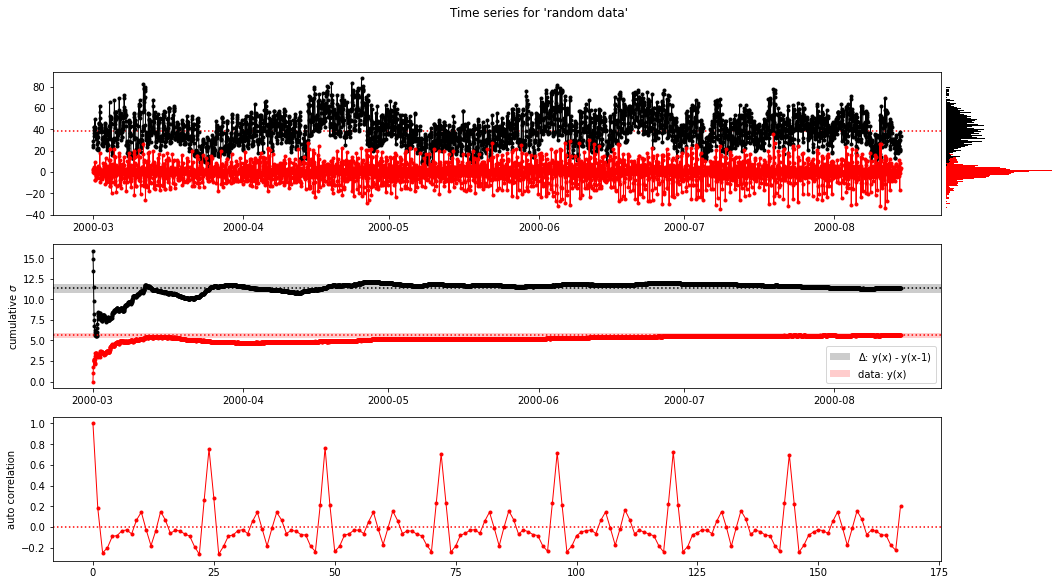

In [46]:
var = 'cldarea_low_1h'
interval = slice(0,4000)

x = ceres.time[interval]
y = np.asarray([np.average(timestep) for timestep in ceres[var][interval]])

fig = time_series_boxplot(x,y,'random data', companion='hist', max_lag=24*7)
plt.show()